In [ ]:
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tsa.stattools import adfuller
import numpy as np

: 

In [3]:

df=pd.read_csv('AirPassengers.csv')
df.head()
df.shape

(144, 2)

In [4]:
df.columns

Index(['Month', '#Passengers'], dtype='object')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Month        144 non-null    object
 1   #Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [6]:
df.describe()

,#Passengers
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


In [7]:
df['Date'] = pd.to_datetime(df['Month'])
df = df.drop(columns = 'Month')
df = df.set_index('Date')
df = df.rename(columns = {'#Passengers':'Passengers'})
df.head()

,Passengers
Date,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


<AxesSubplot:xlabel='Date'>

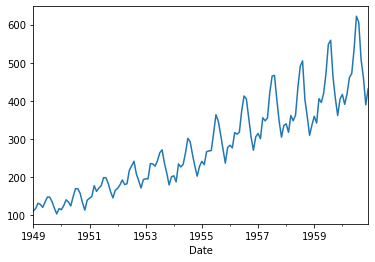

In [8]:
df['Passengers'].plot()

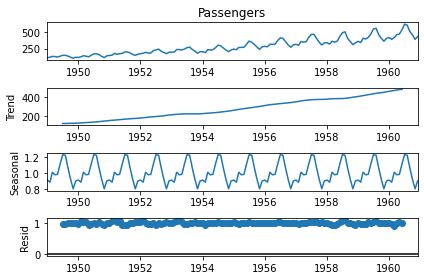

In [9]:
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
dec = sm.tsa.seasonal_decompose(df['Passengers'],
                period = 12, model = 'multiplicative').plot()
plt.show()

In [10]:
#avant de pouvoir construire un modèle, nous devons nous
#assurer que la série temporelle est stationnaire
result = adfuller(df['Passengers'])
 
print('Statistiques ADF : {}'.format(result[0]))
print('p-value : {}'.format(result[1]))
print('Valeurs Critiques :')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

Statistiques ADF : 0.8153688792060423
p-value : 0.9918802434376409
Valeurs Critiques :
	1%: -3.4816817173418295
	5%: -2.8840418343195267
	10%: -2.578770059171598


In [11]:
#La statistique ADF est loin des valeurs critiques et la p-value est supérieure au seuil (0,05).
#On peut donc conclure que la série temporelle n’est pas stationnaire.

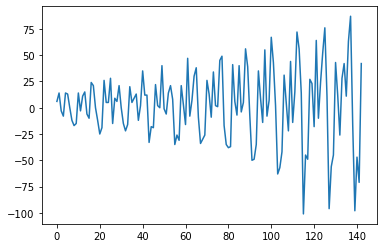

In [25]:
#il faut rendre la serie stationnaire(La moyenne/la varience/ la covarience de la série ne doit pas être fonction du temps)
# et pour la rendre stationnaire on va appliquer la methode du differencing 
# enlever le trend
diff = list()

for i in range(1, len(df['Passengers'])):

    value = df['Passengers'][i] - df['Passengers'][i - 1]

    diff.append(value)

pyplot.plot(diff)

pyplot.show()


In [26]:
result = adfuller(diff)
 
print('Statistiques ADF : {}'.format(result[0]))
print('p-value : {}'.format(result[1]))
print('Valeurs Critiques :')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

Statistiques ADF : -2.8292668241699874
p-value : 0.05421329028382711
Valeurs Critiques :
	1%: -3.4816817173418295
	5%: -2.8840418343195267
	10%: -2.578770059171598


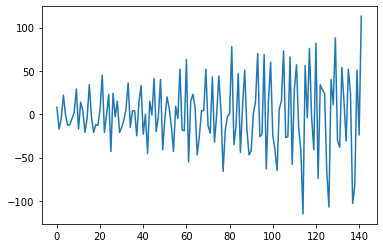

In [52]:
diff2 = list()

for i in range(1, len(diff)):

    value = diff[i] - diff[i - 1]

    diff2.append(value)

pyplot.plot(diff2)

pyplot.show()

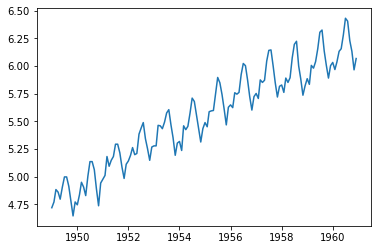

In [20]:
df_log = np.log(df['Passengers'])
plt.plot(df_log)

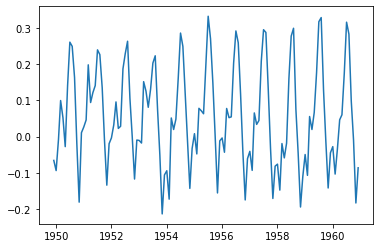

In [21]:
rolling_mean = df_log.rolling(window=12).mean()
df_log_minus_mean = df_log - rolling_mean
df_log_minus_mean.dropna(inplace=True)
plt.plot(df_log_minus_mean)


In [16]:
dataset = df_log_minus_mean.values.reshape(-1,1)
dataset = dataset.astype('float32')
dataset.shape

(133, 1)

In [17]:
result = adfuller(df_log_minus_mean)
 
print('Statistiques ADF : {}'.format(result[0]))
print('p-value : {}'.format(result[1]))
print('Valeurs Critiques :')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

Statistiques ADF : -3.164968129955147
p-value : 0.02210413947387874
Valeurs Critiques :
	1%: -3.4865346059036564
	5%: -2.8861509858476264
	10%: -2.579896092790057


In [170]:
# la serie maintenant est bien stationnaire

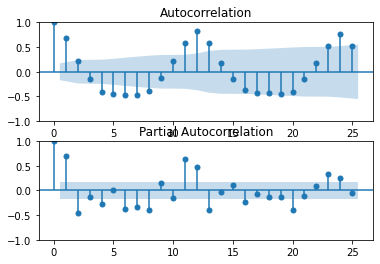

In [171]:
# recherche des valeur des p,d et q
#vu qu'on a appliquer la methode differencing une seule fois donc le d=1
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
pyplot.subplot(211)
plot_acf(dataset, lags=25, ax=pyplot.gca())
pyplot.subplot(212)
plot_pacf(dataset, lags=25, ax=pyplot.gca())
pyplot.show()

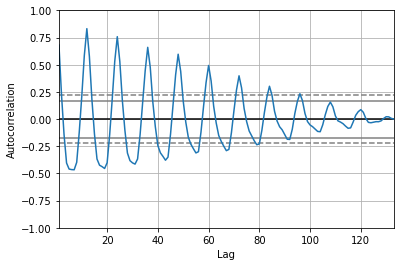

In [87]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df_log_minus_mean)
pyplot.show()

In [180]:
data_diff = df_log_minus_mean.diff()
data_diff = data_diff.dropna()

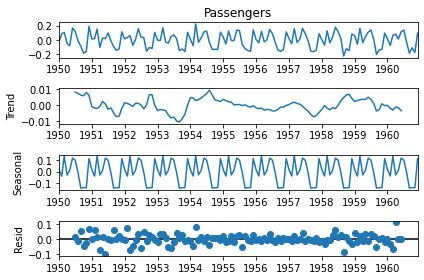

In [182]:
dec = sm.tsa.seasonal_decompose(data_diff,period = 12).plot()
plt.show()

In [183]:
data_diff

Date
1950-01-01   -0.027955
1950-02-01    0.085883
1950-03-01    0.106981
1950-04-01   -0.047274
1950-05-01   -0.079671
                ...   
1960-08-01   -0.032788
1960-09-01   -0.184128
1960-10-01   -0.107465
1960-11-01   -0.173460
1960-12-01    0.096901
Name: Passengers, Length: 132, dtype: float64

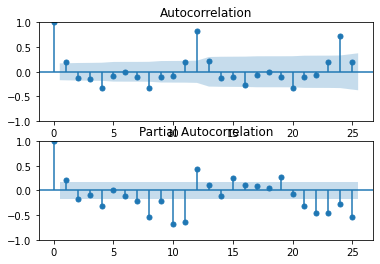

In [184]:
pyplot.subplot(211)
plot_acf(data_diff, lags=25, ax=pyplot.gca())
pyplot.subplot(212)
plot_pacf(data_diff, lags=25, ax=pyplot.gca())
pyplot.show()

In [186]:
#q:Valeur de décalage où le graphique d'autocorrélation (ACF) croise l'intervalle de confiance supérieur pour la 1ère instance.
#p: Valeur de décalage où le graphique d'autocorrélation partielle (PACF) se coupe ou tombe à 0 pour la 1ère instance.

In [ ]:
# dans ce cas p=2 et q=2

In [187]:
def evaluate_arima_model(X, arima_order): # prepare training dataset
    X = X.astype('float32')
    train_size = int(len(X) * 0.50)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        # difference data
        
        model = ARIMA(diff, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse

In [188]:

def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(dataset, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order 
                    print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    continue
    print('Best ARIMA %s RMSE=%.3f' % (best_cfg, best_score))

In [189]:
p_values = range(0, 3)
d_values = range(0, 3)
q_values = range(0, 3)

evaluate_models(df['Passengers'], p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=385.144
ARIMA(0, 0, 1) RMSE=359.021
ARIMA(0, 0, 2) RMSE=338.705
ARIMA(0, 1, 0) RMSE=346.495
ARIMA(0, 1, 1) RMSE=385.147
ARIMA(0, 1, 2) RMSE=358.497
ARIMA(0, 2, 0) RMSE=238.665
ARIMA(0, 2, 1) RMSE=346.249
ARIMA(0, 2, 2) RMSE=384.765
ARIMA(1, 0, 0) RMSE=373.353
ARIMA(1, 0, 1) RMSE=343.028
ARIMA(1, 0, 2) RMSE=339.467
ARIMA(1, 1, 0) RMSE=368.565
ARIMA(1, 1, 1) RMSE=372.932
ARIMA(1, 1, 2) RMSE=342.664
ARIMA(1, 2, 0) RMSE=302.925
ARIMA(1, 2, 1) RMSE=367.769
ARIMA(1, 2, 2) RMSE=323.846
ARIMA(2, 0, 0) RMSE=353.854
ARIMA(2, 0, 1) RMSE=349.630
ARIMA(2, 0, 2) RMSE=385.135
ARIMA(2, 1, 0) RMSE=367.964
ARIMA(2, 1, 1) RMSE=354.040
ARIMA(2, 1, 2) RMSE=344.659
ARIMA(2, 2, 0) RMSE=299.286
ARIMA(2, 2, 1) RMSE=367.450
ARIMA(2, 2, 2) RMSE=343.403
Best ARIMA (0, 2, 0) RMSE=238.665


In [190]:
p_values = range(0, 3)
d_values = range(0, 3)
q_values = range(0, 3)

evaluate_models(data_diff, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=2.245
ARIMA(0, 0, 1) RMSE=29.090
ARIMA(0, 0, 2) RMSE=50.051
ARIMA(0, 1, 0) RMSE=42.005
ARIMA(0, 1, 1) RMSE=2.241
ARIMA(0, 1, 2) RMSE=29.629
ARIMA(0, 2, 0) RMSE=155.004
ARIMA(0, 2, 1) RMSE=42.259
ARIMA(0, 2, 2) RMSE=2.633
ARIMA(1, 0, 0) RMSE=14.347
ARIMA(1, 0, 1) RMSE=45.585
ARIMA(1, 0, 2) RMSE=49.264
ARIMA(1, 1, 0) RMSE=19.269
ARIMA(1, 1, 1) RMSE=14.781
ARIMA(1, 1, 2) RMSE=45.960
ARIMA(1, 2, 0) RMSE=87.189
ARIMA(1, 2, 1) RMSE=20.087
ARIMA(1, 2, 2) RMSE=65.436
ARIMA(2, 0, 0) RMSE=34.413
ARIMA(2, 0, 1) RMSE=38.769
ARIMA(2, 0, 2) RMSE=2.254
ARIMA(2, 1, 0) RMSE=19.886
ARIMA(2, 1, 1) RMSE=34.222
ARIMA(2, 1, 2) RMSE=43.899
ARIMA(2, 2, 0) RMSE=90.986
ARIMA(2, 2, 1) RMSE=20.415
ARIMA(2, 2, 2) RMSE=45.197
Best ARIMA (0, 1, 1) RMSE=2.241


In [224]:
model = ARIMA(df['Passengers'],order = (2,1,2))
model_fit = model.fit()
print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                  144
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -671.673
Date:                Mon, 16 Jan 2023   AIC                           1353.347
Time:                        15:19:46   BIC                           1368.161
Sample:                    01-01-1949   HQIC                          1359.366
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.6850      0.020     83.061      0.000       1.645       1.725
ar.L2         -0.9549      0.017    -55.421      0.000      -0.989      -0.921
ma.L1         -1.8432      0.124    -14.867      0.0

In [225]:
modelsize = int(len(df) - 30)
train, test = df['Passengers'][0:modelsize], df['Passengers'][modelsize:len(df)]

print('\t ARIMA MODEL : In- Sample Forecasting \n')

history = [x for x in train]
predictions = []

for t in range(len(test)):
    
    model = ARIMA(history, order=(2,1,2))
    model_fit = model.fit()
    
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(float(yhat))
    
    obs = test[t]
    history.append(obs)
    
    print('predicted = %f, expected = %f' % (yhat, obs))

	 ARIMA MODEL : In- Sample Forecasting 

predicted = 435.368729, expected = 491.000000
predicted = 487.825560, expected = 505.000000
predicted = 484.761914, expected = 404.000000
predicted = 359.074739, expected = 359.000000
predicted = 380.902398, expected = 310.000000
predicted = 291.230413, expected = 337.000000
predicted = 336.938685, expected = 360.000000
predicted = 367.621771, expected = 342.000000
predicted = 360.294688, expected = 406.000000
predicted = 414.083702, expected = 396.000000
predicted = 378.520878, expected = 420.000000
predicted = 424.478621, expected = 472.000000
predicted = 459.477027, expected = 548.000000
predicted = 534.244217, expected = 559.000000
predicted = 523.514385, expected = 463.000000
predicted = 417.609391, expected = 407.000000
predicted = 366.687599, expected = 362.000000
predicted = 339.214581, expected = 405.000000
predicted = 411.312453, expected = 417.000000
predicted = 435.938031, expected = 391.000000
predicted = 418.796171, expected = 419.

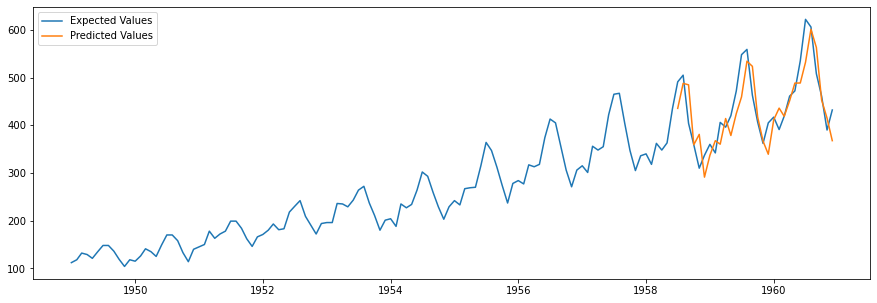

In [226]:
import matplotlib.pyplot as plt
predictions_series = pd.Series(predictions, index = test.index)
fig,ax = plt.subplots(nrows = 1,ncols = 1,figsize = (15,5))

plt.subplot(1,1,1)
plt.plot(df['Passengers'],label = 'Expected Values')
plt.plot(predictions_series,label = 'Predicted Values');
plt.legend(loc="upper left")
plt.show()